# Exploratory Data Analysis and Data Preparation

This notebook explores the **HDF5-based** dataset (as described in the PDF) and prepares it for Vision Transformer (ViT) based segmentation.

## Contents
1. Setup and Imports
2. Data Loading and Inspection (HDF5)
3. Exploratory Data Analysis
4. Data Preprocessing (HDF5 -> Torch Dataset)
5. Physics-based Feature Engineering
6. Data Preparation for ViT
7. Loading HDF5 Dataset with Pandas

In [6]:
# 1) Setup and Imports
import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_context('notebook')

## 1. Setup and Configuration

We will open the HDF5 file using a config-based path retrieval (`get_dataset_path`). The PDF describes that images and masks reside within different internal groups, such as:

- `slices/camera_data/visible/0` (images captured after each layer is melted)
- `slices/camera_data/visible/1` (images captured after new powder is spread)
- `slices/segmentation_results/0..11` (binary masks for each anomaly class, per layer)

We can select which slice or segmentation data we want to examine (e.g. `0` for Powder, `1` for Printed, etc.).

In [3]:
from src.config import get_dataset_path

path_file = get_dataset_path("tcr_phase1_build1")
if path_file is None:
    raise FileNotFoundError("Dataset not found. Please check the configuration and data directory.")

print("Using HDF5 file:", path_file)

Using HDF5 file: /data/2021-07-13 TCR Phase 1 Build 1.hdf5


## 2. Data Loading and Inspection (HDF5)

We’ll open the HDF5 file and look at:
- Top-level metadata
- The shape and content of the slice images (`slices/camera_data/visible/0`)
- The shape and content of segmentation results (`slices/segmentation_results/0`, `1`, etc.)

In [4]:
with h5py.File(path_file, "r") as f:
    print("\nTop-level Attributes (Build Metadata):")
    for k, v in f.attrs.items():
        print(f"  {k} : {v}")

    # Example check: shapes of certain datasets
    slice_dset_name = "slices/camera_data/visible/0"  # post-melt images
    seg_dset_name   = "slices/segmentation_results/1" # anomaly class=1 = 'Printed' (for example)

    print("\nChecking if these datasets exist in the HDF5...")
    if slice_dset_name in f:
        ds_slice = f[slice_dset_name]
        print(f"{slice_dset_name} shape = {ds_slice.shape}")
    else:
        print(f"Dataset {slice_dset_name} NOT FOUND.")

    if seg_dset_name in f:
        ds_seg = f[seg_dset_name]
        print(f"{seg_dset_name} shape = {ds_seg.shape}")
    else:
        print(f"Dataset {seg_dset_name} NOT FOUND.")


Top-level Attributes (Build Metadata):
  core/build_name : TCR Phase 1 Build 1
  core/change_log : 
2021/07/22 14:51:44 v20.9.3: Chase Joslin [3cj] instantiated the change log 
2021/07/22 14:51:44 v20.9.3: Chase Joslin [3cj] created a new analysis file 
<> 2021/07/22 14:51:44: build name: TCR Phase 1 Build 1
<> 2021/07/22 14:51:44: build start date: 2021-07-13
<> 2021/07/22 14:51:44: using workspace: ConceptLaser M2 v3
<> 2021/07/22 14:51:44: using calibration file: ORNL1+20210414
<> 2021/07/22 14:51:44: using live configuration file: none
<> 2021/07/22 14:51:44: using stitching configuration file: none
<> 2021/07/22 14:51:44: dataset sensitivity marked as: False
<> 2021/07/22 14:51:44: loaded the workspace file created on: 2021-07-21_17-37-02
<> 2021/07/22 14:51:44: loaded the ORNL1+20210414 calibration file created on: 2021-04-14_17-21-42
<> 2021/07/22 14:51:45: loaded the DSCNN model created on: 2021-04-25_09-23-51
<> 2021/07/22 14:51:46: loaded the DSCNN-P model created on: 2021-0

### Listing HDF5 Structure
If you want to see the entire group/dataset hierarchy, uncomment below to walk the file’s structure.

In [7]:
# with h5py.File(path_file, "r") as f:
#     def print_structure(name, obj):
#         print(name)
#     print("\n--- HDF5 Structure ---")
#     f.visititems(print_structure)


--- HDF5 Structure ---
parts
parts/process_parameters
parts/process_parameters/hatch_spacing
parts/process_parameters/laser_beam_power
parts/process_parameters/laser_beam_speed
parts/process_parameters/laser_module
parts/process_parameters/laser_spot_size
parts/process_parameters/parameter_set
parts/process_parameters/scan_rotation
parts/process_parameters/stripe_width
parts/test_results
reference_images
reference_images/DSC04467A
reference_images/DSC04468A
reference_images/DSC04469A
reference_images/DSC04470A
reference_images/DSC04471A
reference_images/thumbnail
samples
samples/test_results
samples/test_results/total_elongation
samples/test_results/ultimate_tensile_strength
samples/test_results/uniform_elongation
samples/test_results/yield_strength
scans
scans/0
scans/1
scans/10
scans/100
scans/1000
scans/1001
scans/1002
scans/1003
scans/1004
scans/1005
scans/1006
scans/1007
scans/1008
scans/1009
scans/101
scans/1010
scans/1011
scans/1012
scans/1013
scans/1014
scans/1015
scans/1016
s

## 3. Exploratory Data Analysis

We’ll pick a few random layers from `slices/camera_data/visible/0` and compute basic stats.
Note that `ds_slice[layer]` is a 2D array (height, width).

In [15]:
import random

def get_slice_stats(h5_file, dset_name, num_samples=5):
    """Compute mean/std/min/max for a few random layers."""
    if dset_name not in h5_file:
        print(f"Dataset '{dset_name}' not found!")
        return
    ds = h5_file[dset_name]
    num_layers = ds.shape[0]
    layer_indices = random.sample(range(num_layers), min(num_layers, num_samples))

    for layer_idx in layer_indices:
        arr = ds[layer_idx, ...]
        mean_val = arr.mean()
        std_val = arr.std()
        min_val = arr.min()
        max_val = arr.max()
        print(f"Layer {layer_idx}: mean={mean_val:.3f}, std={std_val:.3f}, min={min_val}, max={max_val}")

with h5py.File(path_file, "r") as f:
    print("\nSample stats from 'slices/camera_data/visible/0':")
    get_slice_stats(f, "slices/camera_data/visible/0", num_samples=3)


Sample stats from 'slices/camera_data/visible/0':
Layer 2956: mean=104.526, std=9.432, min=59.0, max=255.0
Layer 1726: mean=104.502, std=9.087, min=59.0, max=255.0
Layer 1592: mean=103.806, std=9.970, min=54.0, max=255.0


We can also **visualize** a single layer’s slice image to see how it looks.

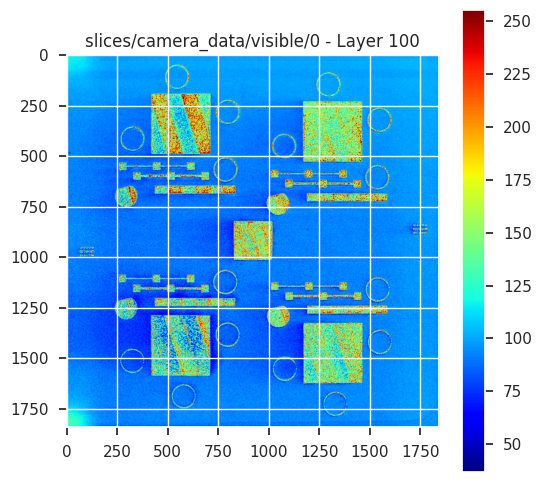

In [16]:
def plot_layer_image(h5_file, dset_name, layer_idx=100, cmap='gray'):
    if dset_name not in h5_file:
        print(f"Dataset '{dset_name}' not found!")
        return
    ds = h5_file[dset_name]
    if layer_idx < 0 or layer_idx >= ds.shape[0]:
        print(f"layer_idx {layer_idx} out of range!")
        return

    img_2d = ds[layer_idx, ...]
    plt.figure(figsize=(6,6))
    plt.imshow(img_2d, cmap=cmap)
    plt.title(f"{dset_name} - Layer {layer_idx}")
    plt.colorbar()
    plt.show()

with h5py.File(path_file, "r") as f:
    # Example: show layer 100 from post-melt images
    plot_layer_image(f, "slices/camera_data/visible/0", layer_idx=100, cmap='jet')

## 4. Data Preprocessing (HDF5 -> Torch Dataset)

Instead of reading PNG files, we define a custom PyTorch `Dataset` that reads directly from the HDF5 file. For each index (which corresponds to a layer), we retrieve:
- An image from `camera_data/visible/0` (for instance)
- A segmentation mask from `slices/segmentation_results/1` (if desired)

Because we have **one HDF5 file** containing many layers, we can open it once in the dataset’s constructor, or pass a path and open lazily. The example below keeps it open, so we must ensure it is closed properly. Alternatively, you can open it in `__getitem__` each time, but that’s slower.

> **Note**: If you want multiple segmentation classes, you might read multiple `slices/segmentation_results/#` arrays, or combine them. Below we just load a single mask dataset for demonstration.

In [17]:
class HDF5MetalDataset(Dataset):
    """Custom dataset reading from HDF5 for images and masks."""
    def __init__(
        self,
        hdf5_path,
        image_dset="slices/camera_data/visible/0",
        mask_dset=None,
        transform=None
    ):
        super().__init__()
        self.hdf5_path = hdf5_path
        self.image_dset_name = image_dset
        self.mask_dset_name = mask_dset
        self.transform = transform

        # Open the file in read-only mode once
        self.h5_file = h5py.File(hdf5_path, 'r')

        if self.image_dset_name not in self.h5_file:
            raise ValueError(f"Image dataset '{self.image_dset_name}' not found in HDF5.")
        self.img_ds = self.h5_file[self.image_dset_name]
        self.num_layers = self.img_ds.shape[0]

        # If mask dataset is specified
        if self.mask_dset_name:
            if self.mask_dset_name not in self.h5_file:
                raise ValueError(f"Mask dataset '{self.mask_dset_name}' not found in HDF5.")
            self.mask_ds = self.h5_file[self.mask_dset_name]
            if self.mask_ds.shape[0] != self.num_layers:
                raise ValueError("Image and mask dataset layer counts do not match!")
        else:
            self.mask_ds = None

    def __len__(self):
        return self.num_layers

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.num_layers:
            raise IndexError("Layer index out of range.")

        # Load the 2D array for the image
        img_2d = self.img_ds[idx, ...].astype(np.float32)
        # Expand to 3-channel if needed for typical models
        # For example, replicate grayscale -> RGB
        img_3ch = np.stack([img_2d, img_2d, img_2d], axis=0)  # shape (3, H, W)

        # Load the 2D array for the mask, if available
        mask_2d = None
        if self.mask_ds is not None:
            mask_2d = self.mask_ds[idx, ...].astype(np.uint8)

        # Convert to PIL or keep in NumPy for transforms?
        # Many Torch transforms expect a PIL Image, but we can also do torchvision.transforms on Tensors.
        # We'll just convert to torch.Tensor below.

        if self.transform:
            # Convert to a Range [0,1], etc., or do standard transforms
            # We'll do the final transform outside of __getitem__ for clarity.
            pass

        # Convert to torch tensors
        img_tensor = torch.from_numpy(img_3ch)  # shape: (3, H, W)
        mask_tensor = None
        if mask_2d is not None:
            mask_tensor = torch.from_numpy(mask_2d)  # shape: (H, W)

        return {
            'image': img_tensor,
            'mask': mask_tensor,
            'layer_index': idx
        }

    def close(self):
        """Close the HDF5 file when done."""
        self.h5_file.close()


## 5. Physics-based Feature Engineering


## 6. Data Preparation for ViT

Let’s create an instance of our `HDF5MetalDataset`, specifying one dataset for images and one for masks. Then we can define standard transforms for the Vision Transformer (e.g. resizing to 224×224). We’ll use `torchvision.transforms` on the Tensor.

Finally, we create a DataLoader for training. When done, remember to call `.close()` on the dataset (or handle it via a context manager) so the HDF5 file is closed properly.

In [19]:
from torchvision import transforms

# Suppose we want to read 'camera_data/visible/0' as images and 'slices/segmentation_results/1' as masks.
image_dset_path = "slices/camera_data/visible/0"
mask_dset_path  = "slices/segmentation_results/1"  # Class=1 (Printed)

# We might define a basic transform that resizes to 224x224, then normalizes.
class ViTResizeTransform:
    def __init__(self, size=224):
        self.size = size
    def __call__(self, sample):
        # sample is a dict with 'image' (3,H,W) and possibly 'mask' (H,W)
        img = sample['image'].float()  # shape: (3, H, W)
        # Convert to CHW -> HWC for resizing with OpenCV or PIL
        # But let's just do it in PyTorch way using transforms.functional
        import torchvision.transforms.functional as F
        img_pil = F.to_pil_image(img)
        img_resized = F.resize(img_pil, (self.size, self.size))
        img_t = F.to_tensor(img_resized)
        # Optionally, do a standard normalization
        # Using typical ImageNet means/stdev:
        img_t = F.normalize(img_t, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        sample['image'] = img_t

        if sample['mask'] is not None:
            mask = sample['mask']
            # Convert (H,W) -> PIL -> resize
            mask_pil = F.to_pil_image(mask.unsqueeze(0))  # expand dims to (1,H,W)
            mask_resized = F.resize(mask_pil, (self.size, self.size), interpolation=F.InterpolationMode.NEAREST)
            mask_t = torch.as_tensor(np.array(mask_resized), dtype=torch.long)
            sample['mask'] = mask_t

        return sample

dataset = HDF5MetalDataset(
    hdf5_path=path_file,
    image_dset=image_dset_path,
    mask_dset=mask_dset_path
)

print("Number of layers in dataset =", len(dataset))

# We'll define a small wrapper dataset that applies transforms to each item.
class TransformWrapper(Dataset):
    def __init__(self, base_dataset, transform):
        self.base = base_dataset
        self.transform = transform
    def __len__(self):
        return len(self.base)
    def __getitem__(self, idx):
        sample = self.base[idx]
        sample = self.transform(sample)
        return sample

vit_transform = ViTResizeTransform(size=224)
wrapped_dataset = TransformWrapper(dataset, vit_transform)

# Now create a DataLoader
dataloader = DataLoader(
    wrapped_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0  # set to >0 if it suits your environment
)

# Let's check a single batch
batch = next(iter(dataloader))
print("Batch keys:", batch.keys() if isinstance(batch, dict) else batch[0].keys())
print("Images shape:", batch['image'].shape)
if batch['mask'] is not None:
    print("Masks shape:", batch['mask'].shape)
print("Layer indices:", batch['layer_index'])

# Make sure to close the underlying HDF5 file when done:
dataset.close()

Number of layers in dataset = 3575
Batch keys: dict_keys(['image', 'mask', 'layer_index'])
Images shape: torch.Size([4, 3, 224, 224])
Masks shape: torch.Size([4, 224, 224])
Layer indices: tensor([ 313, 1780, 1340, 2842])
